## Dataset information:
<blockquote>
                This dataset comprises information of 25000 mutual funds in the United states.
            Various attributes related to the mutual fund have been described and these
            attributes will be used for making decisions on the rating of the mutual fund by
            GreatStone which is a top mutual fund rating agency.
            The following files are provided in the form of CSVs. These files contain various
            attributes related to the mutual fund. Please find the following files for the
            same:
            bond_ratings, fund_allocations, fund_config, fund_ratios, fund_specs, other_specs, return_3year, return_5year, return_10year. 
</blockquote>
    
## Files Description:

<blockquote>
    <ul>
        <li>bond_ratings consists of 12 columns which provide information on the
bond rating percentage allocation of the mutual funds</li>
        <li>fund_allocations consists of 12 columns which provide information on the
sector wise percentage allocation of the mutual funds</li>
        <li>fund_config comprises of 4 columns which comprise the metadata of the
mutual funds</li>
        <li>fund_ratios consists of 8 columns which provides information on various
fundamental ratios that describe the mutual funds</li>
        <li>fund_specs contains 9 columns which give information about the specifications of the mutual funds</li>
        <li>other_specs contains 43 columns which give information of the other
aspects of the mutual funds</li>
        <li>return_3years contains 17 columns which give information about 3 year
return and ratios</li>
        <li>return_5years contains 17 columns which give information about 3 year
return and ratios</li>
        <li>return_10years contains 17 columns which give information about 3 year
return and ratios</li>
        <li>sample_submission contains the fund ids for which you need to provide
the ratings for the submission file. Please maintain the order of the fund
ids as shown in this file.</li>
        <li>The tag column is a unique identifier and is also the same as the id.(i.e tag
= id)</li>
    </ul>
</blockquote>

## Goal: 
<blockquote>
The goal of this hackathon is to predict GreatStone’s
rating of a mutual fund. In order to help investors decide
on which mutual fund to pick for an investment, the task is
to build a model that can predict the rating of a mutual
fund. The various attributes that define a mutual fund can
be used for building the model.
</blockquote>

## Great Stone Rating 
<blockquote>Great Stone Rating is a star based ranking system.
These ratings are based on the performance of a mutual
fund with adjustments for risks and costs as compared to
other funds in the same category. The rating ranges from
0 to 5.</blockquote>

## Library Import 

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import math

# Model metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

#Preprocessor
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer

# Import logistic, tree models
from sklearn.tree import DecisionTreeClassifier
#!pip install catboost
from catboost import CatBoostClassifier

# import model metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

# Import model tuning 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Other imports
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 


# To display matplot diagram in inline
%matplotlib inline

In [2]:
# To display all the variable values / full output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Ignore ipython warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_common_columns(df1, df2):
    """Get common columns between dataframes"""
    
    common_columns = set(df1.columns)
    common_columns &= set(df2.columns)
    
    return list(common_columns)

In [58]:
def _get_dataframe(filenames, df_master, start_index=1):
    ''' get data frame from files'''
    
    reprocess_list = []
    
    print(start_index)
    
    # Iterate the filenames and append the data
    for f in filenames[start_index:]:
        print(f)
        df_tmp = pd.read_csv(f)
        
        # Get common column names
        common_columns = get_common_columns(df_master, df_tmp)
            
        if(len(common_columns)>0): # Atleast one common column between the dataframes
            df_master = pd.merge(left=df_master, right=df_tmp, left_on=common_columns, right_on=common_columns, how='inner')
        
        elif(f.find('fund_allocation')!=-1): # Special case #1: fund_allocation file doens't have common column but 'id' represents the 'tag'
            df_master = pd.merge(left=df_master, right=df_tmp, left_on=['tag'], right_on=['id'], how='inner')
        
        else: # There is no common columns, store it in array for later reprocessing
            print('reprocess:', f)
            reprocess_list.append(f)
            
    print('Reprocess count:', len(reprocess_list))
    if(len(reprocess_list)>0): # Reprocess the files which is not merged
        print('Reprocessing....')
        df_master, reprocess_list = _get_dataframe(reprocess_list, df_master, 0)
        
    return [df_master, reprocess_list]

def get_master_dataframe(base_dir, file_type):
    ''' This method returns the dataframe of all the file content'''
    
    # Read all the filenames
    filenames = glob(base_dir+"/*."+file_type) # Total - 9 files, number of rows in each file - 25000, total columns from all the files - 139 (including duplicates)
    # Read first file
    df_master = pd.read_csv(filenames[0])
    
    # Get Master dataframe
    df_master, reprocess_list = _get_dataframe(filenames, df_master)
    
    return df_master

master_df = get_master_dataframe(base_dir='data', file_type='csv')
master_df.shape
master_df.to_csv('master_data.csv', index=False)

1
data/fund_specs.csv
data/fund_allocations.csv
data/fund_ratios.csv
data/return_3year.csv
data/return_5year.csv
data/fund_config.csv
data/return_10year.csv
data/other_specs.csv
Reprocess count: 0


(25000, 125)

In [59]:
# Take out the result/prediction rows
prediction_df = master_df[master_df['greatstone_rating'].isnull()] # This dataframe will be used for prediction
prediction_df.shape
df = master_df[~master_df['greatstone_rating'].isnull()] # This dataframe will be used for training, validation and testing
df.shape
df.to_csv('data.csv', index=False)
prediction_df.to_csv('predict_result.csv', index=False)
prediction_df.shape

(5000, 125)

(20000, 125)

(5000, 125)

## EDA

In [60]:
### DROPPIGN COLUMN which has more null value
threshold = 0.5
df_backup=df.copy()
df_backup.shape
#Dropping columns with missing value rate higher than threshold
df = df[df.columns[df.isnull().mean() < threshold]]

#Dropping rows with missing value rate higher than threshold
df = df.loc[df.isnull().mean(axis=1) < threshold]
df.shape

(20000, 125)

(19912, 123)

In [61]:
## Remove unique ID column and unwanted date column
df.drop(['fund_id','currency','inception_date'], axis=1, inplace=True, errors='ignore')
# df.mean()

In [ ]:
#Convert the Categorical variable type to category from int data type
df['inception_date'] = pd.to_datetime(df['inception_date'], format='%Y-%m-%d')
# df['Year'] = df['inception_date'].dt.year.astype('category')
# df['Month'] = df['inception_date'].dt.month.astype('category')
# df['DayOfMonth'] = df['inception_date'].dt.day.astype('category')
# df['Weekday'] = df['inception_date'].dt.dayofweek.astype('category')
# df['DayOfYear'] = df['inception_date'].dt.dayofyear.astype('category')

df['Year'] = df['inception_date'].dt.year
df['Month'] = df['inception_date'].dt.month
df['DayOfMonth'] = df['inception_date'].dt.day
df['Weekday'] = df['inception_date'].dt.dayofweek
df['DayOfYear'] = df['inception_date'].dt.dayofyear
df['inception_date'] = df['inception_date'].astype(int)/1e12
df = df.sort_values('inception_date').reset_index(drop=True)
df.shape

#### OneHot label encorder and Impute the mean

In [62]:
# From above result, the following columns are not a categorical
# 3yrs_treynor_ratio_fund, 5yrs_treynor_ratio_fund, ps_ratio, mmc, pc_ratio, pe_ratio, 10yrs_treynor_ratio_fund
# And categorical columns are
# investment_class, inception_date, fund_size


## Convert all the non categorical columns to numeric
categorical_columns = ['3yrs_treynor_ratio_fund', 'ps_ratio', 'mmc', 'pc_ratio', 'pe_ratio','5yrs_treynor_ratio_fund', '10yrs_treynor_ratio_fund']
for col in categorical_columns:
    df[col] = df[col].replace(',','', regex=True).astype('float')


In [63]:
    
## Converting all the categorical column values to numeric
replaceStruct = {
    "investment_class": {'Blend': 1, 'Growth': 2, 'Value': 3, np.NaN: 0},
    "fund_size": {'Large': 1, 'Medium': 2, 'Small': 3, np.NaN: 0}
}

df.replace(replaceStruct, inplace=True, )

df['investment_class'] = df['investment_class'].astype('float')
df['fund_size'] = df['fund_size'].astype('float')

In [64]:
le = LabelEncoder() 

obj_col_list = df.select_dtypes('object').columns.tolist()
obj_col_list
for col in obj_col_list:
    df[col] = df[~df[col].isnull()]
    df[col] = le.fit_transform(df[col])


df[obj_col_list].info()

['category', 'parent_company', 'fund_name']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19912 entries, 1 to 24997
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   category        19912 non-null  int64
 1   parent_company  19912 non-null  int64
 2   fund_name       19912 non-null  int64
dtypes: int64(3)
memory usage: 622.2 KB


In [12]:
def getUnique_Highly_Correlated_Columns(df):
    '''
    Get a list of duplicate columns. and column which has unique data and highly correlated in positively and negatively.
    :param df: Dataframe object
    :return: List of columns which is unwanted (contains unique data or highly correlated).
    '''
    target_col = 'greatstone_rating'
    unwantedColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        col = df.iloc[:, x]
        x_col_name = df.columns[x]
        if(df[x_col_name].nunique() == 1 or df[x_col_name].nunique() == df.shape[0]): # Remove if All the values in columns are unique
            unwantedColumnNames.add(x_col_name)
        else:
            # Iterate over all the columns in DataFrame from (x+1)th index till end
            for y in range(x + 1, df.shape[1]):
                
                y_col_name = df.columns[y]
                if( (target_col!=x_col_name and target_col!= y_col_name) and (df.dtypes[x_col_name] != np.object) and (df.dtypes[y_col_name] != np.object)):
                    corr = df[x_col_name].corr(df[y_col_name])
                    if math.isnan(corr) == False and ~(-0.75 < corr < 0.75): # Find the correlation between the columns and remove postive and negatively correlated
                        #print(x_col_name,'--',y_col_name,' corr:', corr)
                        unwantedColumnNames.add(x_col_name)
                        break
    
    # Add ignore columns
    if target_col in unwantedColumnNames: unwantedColumnNames.remove(target_col)
    if 'parent_company' in unwantedColumnNames: unwantedColumnNames.remove('parent_company')

    print('Unwanted columns:', list(unwantedColumnNames),"\ncount:",len(list(unwantedColumnNames)))
    return list(unwantedColumnNames)

In [29]:
df.to_csv('data_with_unwanted_col.csv', index=False)
unwantedCol = getUnique_Highly_Correlated_Columns(df)


# df.drop(columns = unwantedCol, inplace=True, errors='ignore')
df.shape

Unwanted columns: ['fund_return_3years', '5_years_alpha_category', '2018_return_category', 'tag', '3_years_alpha_category', '2013_return_fund', '3_years_return_mean_annual_fund', '10_years_return_mean_annual_fund', 'return_ytd', 'fund_beta_3years', 'fund_return_3months', '5_years_return_fund', 'ytd_return_category', '2016_return_fund', '5_years_return_mean_annual_category', 'ytd_return_fund', '5_years_alpha_fund', '10_years_alpha_fund', '2010_return_fund', 'category_beta_3years', 'us_govt_bond_rating', '3_years_return_category', '5years_category_std', '10_years_return_mean_annual_category', 'years_up', 'category_r_squared_5years', '2014_category_return', '5yrs_sharpe_ratio_fund', '5_years_return_mean_annual_fund', '2012_return_category', 'id', '10_years_return_category', '3years_fund_std', '5years_fund_std', '3_months_return_category', 'inception_date', 'Month', '2017_category_return', '2011_return_category', '2015_return_fund', '3years_fund_r_squared', 'bb_rating', '3_years_alpha_fund

(19912, 126)

In [30]:
df.groupby('greatstone_rating').mean()

,bb_rating,us_govt_bond_rating,below_b_rating,others_rating,b_rating,tag,a_rating,aaa_rating,aa_rating,bbb_rating,...,1_month_fund_return,bond_percentage_of_porfolio,portfolio_preferred,2010_return_category,2013_category_return,Year,Month,DayOfMonth,Weekday,DayOfYear
greatstone_rating,,,,,,,,,,,,,,,,,,,,,
0.0,3.014418,0.0,0.605448,0.925100,2.299540,143994.950334,3.854833,12.757650,2.249978,5.945975,...,0.797816,26.521223,0.334418,-18.952857,-9.358611,2015.672350,7.332098,18.655300,2.425500,210.868050
1.0,2.849764,0.0,0.537982,1.789853,2.513601,139705.715859,4.781672,15.001723,4.549315,5.015884,...,0.630169,33.428726,0.287857,11.909681,16.518415,2006.998532,6.659325,20.187225,2.925844,191.762849
2.0,3.194797,0.0,0.657688,1.724252,2.920341,140175.157632,4.612419,13.998465,4.123878,5.279185,...,0.721627,29.066599,0.208675,13.362833,17.180126,2006.082739,6.678554,19.806705,2.857109,191.950071
3.0,3.308785,0.0,0.795700,1.465522,3.145219,139118.439781,5.008639,14.355928,4.151307,5.990395,...,0.930636,29.591083,0.282588,13.636393,17.072329,2006.195655,6.857396,19.994089,2.757352,197.595537
4.0,3.966094,0.0,1.091767,1.943949,3.815313,139045.654348,5.793114,14.625024,4.623240,6.961419,...,1.192486,32.989591,0.351867,13.561193,16.016686,2006.230870,6.935000,19.947609,2.725000,199.912609
5.0,3.992856,0.0,1.013575,2.404656,3.712887,146300.998771,5.926536,17.069435,5.155891,7.591468,...,1.467273,35.862721,0.441923,12.293819,13.995196,2007.693489,6.973587,20.363636,2.783170,201.489558


<Figure size 1080x576 with 0 Axes>

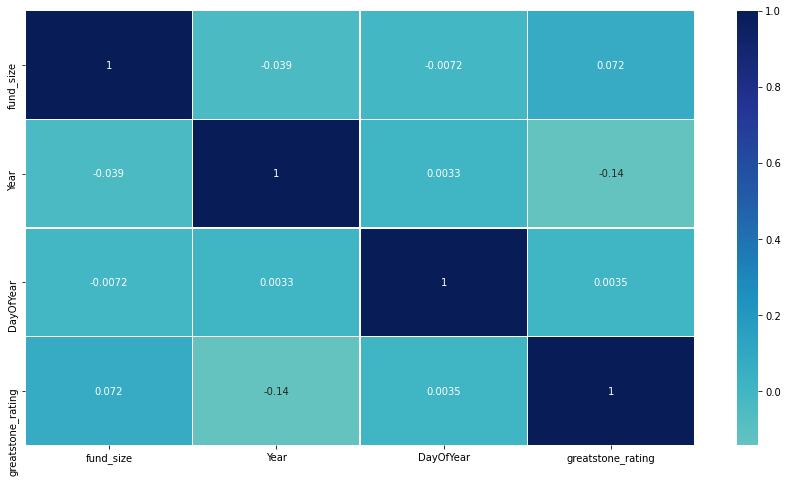

In [31]:

#  Finding a correlation b/w columns

plt.figure(figsize=(15,8))

sns.heatmap(df[['fund_size','Year', 'DayOfYear','greatstone_rating']].corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=True,
            cmap="YlGnBu")

In [65]:
def find_cum_sum(col1, col2='', drop=False):
  filtered_col = []
  for col in df.drop('greatstone_rating', axis=1).columns:
    if( (col.find(col1) != -1) or (col2 != '' and col.find(col2) != -1)):
      filtered_col.append(col)
  df[col1+'_cumsum'] = np.cumsum(df[filtered_col],axis=1).iloc[:,-1]
  df[col1+'_mean'] = df[filtered_col].mean(axis=1, skipna=True)
  if(drop):
    df.drop(columns=filtered_col, axis=1, inplace=True)
    return 
  return df[filtered_col]

In [69]:
df.shape
find_cum_sum('fund_return','return_fund', True)
df.shape

(19912, 110)

(19912, 96)

In [66]:
cols = ['return_category','fund_std','alpha_fund','beta_fund', 'sharpe_ratio_fund', 'treynor_ratio_fund', 'category_return']
for col in cols:
  find_cum_sum(col, drop=True)
df.shape

(19912, 104)

In [67]:
cols = ['fund_r_squared','mean_annual_fund','rating']
for col in cols:
  _ = find_cum_sum(col, drop=False)
df.shape

(19912, 110)

## Handle missing values and outliers

In [70]:
df_tmp = pd.concat([pd.isna(df).sum(),df.dtypes,df.nunique()],axis=1).sort_values(by=0, ascending=False)
df_tmp.head(10)

,0,1,2
return_category_cumsum,9162,float64,128
alpha_fund_cumsum,6808,float64,5602
10_years_return_mean_annual_fund,6808,float64,293
treynor_ratio_fund_cumsum,6808,float64,6286
mean_annual_fund_cumsum,6808,float64,1089
sharpe_ratio_fund_cumsum,6808,float64,1131
beta_fund_cumsum,6808,float64,654
fund_std_cumsum,6808,float64,5879
fund_r_squared_cumsum,6808,float64,9425
10years_fund_r_squared,6808,float64,4700


In [42]:
df_temp = df.copy()
df_temp.shape

# df=df[~df['return_category_cumsum'].isnull()]
# df.dropna(inplace=True)
df.isnull().sum()

(10750, 102)

bb_rating                  0
us_govt_bond_rating        0
below_b_rating             0
others_rating              0
b_rating                   0
                          ..
fund_r_squared_mean        0
mean_annual_fund_cumsum    0
mean_annual_fund_mean      0
rating_cumsum              0
rating_mean                0
Length: 102, dtype: int64

In [71]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Split the target and features
X = df.drop('greatstone_rating', axis=1)
y = df[['greatstone_rating']] # Target column


X_imputed = imputer.fit_transform(X)
X_imputed.shape

(19912, 95)

## Spliting the Data

In [72]:

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=1, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

((15929, 95), (3983, 95), (15929, 1), (3983, 1))

## Common/Global methods
These methods are used commonly, moving these to separate section for easy access

In [73]:
# This function is used to get cross validation scores and model accuracy
def evaluate_save_model(model, train_feature, train_target, test_feature, test_target, model_name, resultsDf=pd.DataFrame()):
    ''' Evaluate model and save the result for future comparision'''
    
    # Cross validation scores
    scores = cross_val_score(model,
                             train_feature,
                             train_target,
                             cv=5,
                             scoring='r2')
    
    # Get model accuracy
    accuracy = model.score(test_feature, test_target)
    
    # Get R2 and Mean
    y_pred = model.predict(test_feature) 
    r2_val = r2_score(test_target, y_pred)
    
    # RMSE - Root Mean Square Error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print('Accuracy: ', accuracy)
    print('R2 value: ', r2_val)
    print('RMSE: ', rmse)
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('-----------------------------------')
    
    result = {'Method':[model_name], 'accuracy': round(accuracy,2), 'r2': round(r2_val,4), 'rmse':round(rmse,4), 
              'mean':round(np.mean(scores),4), 'std': round(np.std(scores),4)}
    
    # Save model result for comparision
    if resultsDf.empty:
        resultsDf = pd.DataFrame(result)
    else:
        tmpResultsDf = pd.DataFrame(result)
        resultsDf = pd.concat([resultsDf, tmpResultsDf])
    
    print(resultsDf.sort_values(by='accuracy',ascending=False).reset_index(drop=True))
    
    return resultsDf.sort_values(by='accuracy',ascending=False).reset_index(drop=True)


## Model building using Logistic Regression

In [74]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_std, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
resultsDf = evaluate_save_model(logreg, X_train_std, y_train, X_test_std, y_test, 'Logistic Reg')

Accuracy:  0.6409741400954054
R2 value:  0.5781314451775381
RMSE:  0.8277450925481282
CV Mean:  0.5902564905615921
STD:  0.009637063339585604
-----------------------------------
         Method  accuracy      r2    rmse    mean     std
0  Logistic Reg      0.64  0.5781  0.8277  0.5903  0.0096


## K-Nearest Neighbors

In [76]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [77]:
resultsDf = evaluate_save_model(knn, X_train, y_train, X_test, y_test, 'KNN', resultsDf)

Accuracy:  0.4381119758975647
R2 value:  -0.04531885954909742
RMSE:  1.302964040172416
CV Mean:  -0.08786480838989888
STD:  0.02206703957226663
-----------------------------------
         Method  accuracy      r2    rmse    mean     std
0  Logistic Reg      0.64  0.5781  0.8277  0.5903  0.0096
1           KNN      0.44 -0.0453  1.3030 -0.0879  0.0221


## Linear Discriminant Analysis

In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_std, y_train)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [49]:
resultsDf = evaluate_save_model(lda, X_train_std, y_train, X_test_std, y_test, 'LDA', resultsDf)

Accuracy:  0.5553602811950791
R2 value:  0.4283831755036466
RMSE:  0.9508377320388809
CV Mean:  0.44116415985058144
STD:  0.019939631428967777
-----------------------------------
         Method  accuracy      r2    rmse    mean     std
0  Logistic Reg      0.63  0.5814  0.8137  0.5946  0.0144
1           KNN      0.56  0.4398  0.9413  0.4276  0.0160
2           LDA      0.56  0.4284  0.9508  0.4412  0.0199


## Support Vector Machine

In [46]:
from sklearn.svm import SVC
svm = SVC(C=1, gamma= 0.01, kernel='rbf')
svm.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [47]:
resultsDf = evaluate_save_model(svm, X_train, y_train, X_test, y_test, 'SVM', resultsDf)

Accuracy:  0.3614457831325301
R2 value:  -0.002052327951920452
RMSE:  1.0870726321780537
CV Mean:  -0.00014710215465694177
STD:  2.531071120954826e-05
-----------------------------------
             Method  accuracy      r2    rmse    mean     std
0  RandomForest_opt      0.81  0.8344  0.4419  0.7879  0.0154
1      RandomForest      0.80  0.8233  0.4564  0.7746  0.0141
2      Logistic Reg      0.74  0.7676  0.5235  0.7326  0.0172
3               SVM      0.36 -0.0021  1.0871 -0.0001  0.0000


## LGBMClassifier

In [106]:
from lightgbm import LGBMClassifier
lgbmModel = LGBMClassifier(n_estimators=2000, objective='multiclass',learning_rate=0.01)
lgbmModel.fit(X_train_std, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=2000, n_jobs=-1, num_leaves=31,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
resultsDf = evaluate_save_model(lgbmModel, X_train_std, y_train, X_test_std, y_test, 'LGBM', resultsDf)

## CatBoostClassifier

In [ ]:
model_catboost = CatBoostClassifier(
    depth=10, iterations= 250, learning_rate= 0.06)
model_catboost.fit(X_train_std, y_train)

In [ ]:
resultsDf = evaluate_save_model(model_catboost, X_train_std, y_train, X_test_std, y_test, 'CatBoost', resultsDf)

In [ ]:
resultsDf

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(random_state=7) #n_estimators = 50, random_state=1,max_features=12)
rfcl = rfcl.fit(X_train, y_train)

In [44]:
resultsDf = evaluate_save_model(rfcl, X_train, y_train, X_test, y_test, 'RandomForest', resultsDf)

Accuracy:  0.8007028112449799
R2 value:  0.8233425165250438
RMSE:  0.45643546458763845
CV Mean:  0.7746131402710508
STD:  0.014111579997435552
-----------------------------------
         Method  accuracy      r2    rmse    mean     std
0  RandomForest      0.80  0.8233  0.4564  0.7746  0.0141
1  Logistic Reg      0.74  0.7676  0.5235  0.7326  0.0172


In [ ]:
params = {'n_estimators': [10,20,50,100, 150, 200], 'criterion':['gini','entropy'], 'bootstrap':[True,False], 'max_depth':[5, 8, 11, 3, 15, 18]}

model1 = GridSearchCV(rfcl, param_grid=params, verbose=5)

model1.fit(X_train, y_train)

print("Best Hyper Parameters:\n", model1.best_params_)

In [86]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(bootstrap= False, criterion='entropy', max_depth=18, n_estimators=150) #n_estimators = 50, random_state=1,max_features=12)
rfcl = rfcl.fit(X_train, y_train)
resultsDf = evaluate_save_model(rfcl, X_train, y_train, X_test, y_test, 'RandomForest_opt', resultsDf)

Accuracy:  0.7961335676625659
R2 value:  0.8585526831577308
RMSE:  0.47929775394003343
CV Mean:  0.8461025834171881
STD:  0.007720058090112144
-----------------------------------
                 Method  accuracy      r2    rmse    mean     std
0      RandomForest_opt      0.80  0.8586  0.4793  0.8461  0.0077
1          Logistic Reg      0.64  0.5781  0.8277  0.5903  0.0096
2                   KNN      0.44 -0.0453  1.3030 -0.0879  0.0221
3  RandomForest_opt_pca      0.32 -0.7696  1.6953  0.3851  0.0189
4  RandomForest_opt_pca      0.24 -0.6337  1.6289  0.5947  0.0110


In [50]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train)
resultsDf = evaluate_save_model(decision_tree, X_train, y_train, X_test, y_test, 'DTree', resultsDf)

Accuracy:  0.7023092369477911
R2 value:  0.673077235400563
RMSE:  0.6209204205650664
CV Mean:  0.5929969596220555
STD:  0.01877837507156831
-----------------------------------
                 Method  accuracy      r2    rmse    mean     std
0      RandomForest_opt      0.81  0.8344  0.4419  0.7879  0.0154
1     RandomForest_opt_      0.81  0.8336  0.4430  0.7931  0.0145
2          RandomForest      0.80  0.8233  0.4564  0.7746  0.0141
3  RandomForest_opt_std      0.76  0.7821  0.5070  0.7904  0.0148
4          Logistic Reg      0.74  0.7676  0.5235  0.7326  0.0172
5                 DTree      0.70  0.6731  0.6209  0.5930  0.0188
6                   SVM      0.36 -0.0021  1.0871 -0.0001  0.0000


## Ensemble Learning - Bagging

In [41]:
from sklearn.ensemble import BaggingClassifier

baggingModel = BaggingClassifier(base_estimator=rfcl, n_estimators=500, max_samples= .7, bootstrap=True, oob_score=True, random_state=1)
baggingModel_predict = baggingModel.fit(X_train_std, y_train)

In [ ]:
resultsDf = evaluate_save_model(baggingModel, X_train_std, y_train, X_test_std, y_test, 'Bagging', resultsDf)

## Feature Importance

In [28]:
feature_imp = pd.DataFrame(sorted(zip(rfcl.feature_importances_, df.drop(['greatstone_rating'],axis=1).columns),reverse=True), columns=['Value','Feature'])
#feature_imp.tail(20)
feature_imp.tail(20)['Feature'].values

# feature_imp = pd.DataFrame(sorted(zip(model_catboost.feature_importances_, df.drop(['greatstone_rating'],axis=1).columns),reverse=True), columns=['Value','Feature'])
# # feature_imp.tail(20)
# feature_imp.tail(20)['Feature'].values


# plt.figure(figsize=(20, 10))
# sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
# plt.title('LightGBM Features (avg over folds)')
# plt.tight_layout()

array(['a_rating', 'bb_rating', 'portfolio_convertable', 'b_rating',
       'fund_name', 'category', 'below_b_rating', 'parent_company',
       '10_years_return_mean_annual_category', 'portfolio_preferred',
       'investment_class', 'fund_size',
       '3_years_return_mean_annual_category',
       '10yrs_sharpe_ratio_category', 'rating_mean', 'rating_cumsum',
       '10_years_beta_category', '5_years_beta_category',
       'category_beta_3years', 'us_govt_bond_rating'], dtype=object)

In [29]:
# Drop the low feature columns
drop_columns = ['a_rating', 'bb_rating', 'portfolio_convertable', 'b_rating',
       'fund_name', 'category', 'below_b_rating', 'parent_company',
       '10_years_return_mean_annual_category', 'portfolio_preferred',
       'investment_class', 'fund_size',
       '3_years_return_mean_annual_category',
       '10yrs_sharpe_ratio_category', 'rating_mean', 'rating_cumsum',
       '10_years_beta_category', '5_years_beta_category',
       'category_beta_3years', 'us_govt_bond_rating'] 

high_columns = ['portfolio_utils_allocation', 'aaa_rating', 'portfolio_convertable', 'below_b_rating', 'aa_rating',
'10years_category_std', 'bbb_rating', 'a_rating', 'portfolio_preferred', 'b_rating', 'investment_class',
'10yrs_sharpe_ratio_category', '5_years_beta_category', 'fund_size', '10_years_beta_category', 'portfolio_consumer_defence_allocation',
'mmc', 'ps_ratio', 'pc_ratio', 'investment_class', 'portfolio_healthcare_allocation', 'portfolio_industrials_allocation', '2011_return_category',
'3years_category_std', '5years_category_std','greatstone_rating']

# columns.append('greatstone_rating')
# df_modified = df.drop(drop_columns, axis=1, errors='ignore')

df_modified = df.drop(columns=drop_columns, axis=1)
X_transform = imputer.fit_transform(df_modified.drop('greatstone_rating',axis=1))
X_transform.shape
df_modified.shape

(19912, 81)

(19912, 82)

In [30]:

#X = df_modified.drop(['greatstone_rating'], axis=1) # Drop target column and columns used only for visualization
X = X_transform
y = df_modified['greatstone_rating'] # Target column


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

((15929, 81), (3983, 81), (15929,), (3983,))

## PCA

In [80]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)




<BarContainer object of 3 artists>

Text(0, 0.5, 'Variation explained')

Text(0.5, 0, 'eigen Value')

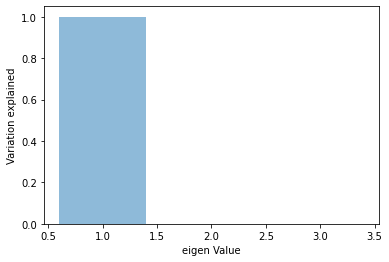

In [82]:
plt.bar(list(range(1,4)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

In [ ]:
plt.step(list(range(1,14)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

In [84]:
pca_opt = PCA(n_components=6)

X_train_pca = pca_opt.fit_transform(X_train_std)
X_test_pca = pca_opt.fit_transform(X_test_std)

In [85]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(bootstrap= False, criterion='entropy', max_depth=18, n_estimators=150) #n_estimators = 50, random_state=1,max_features=12)
rfcl = rfcl.fit(X_train_pca, y_train)
resultsDf = evaluate_save_model(rfcl, X_train_pca, y_train, X_test_pca, y_test, 'RandomForest_opt_pca', resultsDf)

Accuracy:  0.24353502385136833
R2 value:  -0.6336778627203286
RMSE:  1.628888094623269
CV Mean:  0.5947253171321905
STD:  0.010979375193287403
-----------------------------------
                 Method  accuracy      r2    rmse    mean     std
0          Logistic Reg      0.64  0.5781  0.8277  0.5903  0.0096
1                   KNN      0.44 -0.0453  1.3030 -0.0879  0.0221
2  RandomForest_opt_pca      0.32 -0.7696  1.6953  0.3851  0.0189
3  RandomForest_opt_pca      0.24 -0.6337  1.6289  0.5947  0.0110


## GridSearch CV

In [ ]:
# grid = {'iterations':[50, 100, 200],
#         'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
#         # 'subsample': [0.3, 0.05, 0.07],
#         'depth': [4, 6, 8, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}

# grid = {'iterations':[1],
#         'learning_rate': [1],
#         # 'subsample': [0.3, 0.05, 0.07],
#         'depth': [4],
#         'l2_leaf_reg': [3]}

# model = CatBoostClassifier()
# grid_search_result = model.grid_search(grid, 
#                                        X=X_train.drop('fund_id',axis=1), 
#                                        y=y_train, 
#                                        plot=True)


# param_grid = { 'max_depth': [8, 12, 15, 20],
#               'n_estimators': [300, 500, 1000],
#               'learning_rate':[0.3, 0.7, 1.0]
#              }

# Random forest
param_grid = {
    'n_estimators'      : [200, 320,330,340],
    'max_depth'         : [8, 10, 11, 12, 15],
#     'random_state'      : [0],
    'criterion' :['gini','entropy']
}

gs = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)
gs.fit(X_train_std, y_train)

In [ ]:


gs.best_params_
print("========================================================")
gs.best_score_
print("========================================================")
gs.best_estimator_

## Randomized Search CV

In [ ]:
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
#!pip install catboost
from catboost import CatBoostClassifier

model1 = CatBoostClassifier()
parameters = {'depth'         : sp_randInt(6, 15),
              'learning_rate' : sp_randFloat(0.02, 1),
              'iterations'    : sp_randInt(150, 200, 300),
              'l2_leaf_reg'   : sp_randInt(1, 10)
              }


randm = RandomizedSearchCV(estimator=model1, param_distributions = parameters, 
                            cv = 2, n_iter = 10, n_jobs=-1)
randm.fit(X_train, y_train)

In [ ]:

randm.best_params_
print("========================================================")
randm.best_score_
print("========================================================")
randm.best_estimator_

## Optimized model

In [31]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(bootstrap= False, criterion='entropy', max_depth=18, n_estimators=150) #n_estimators = 50, random_state=1,max_features=12)
rfcl = rfcl.fit(X_train, y_train)
resultsDf = evaluate_save_model(rfcl, X_train, y_train, X_test, y_test, 'RandomForest_opt_1', resultsDf)

Accuracy:  0.7130303791112227
R2 value:  0.40203260819834397
RMSE:  0.9725068228356876
CV Mean:  0.8494751650631184
STD:  0.0048048827273136484
-----------------------------------
               Method  accuracy      r2    rmse    mean     std
0    RandomForest_opt      0.79  0.8536  0.4811  0.8473  0.0060
1        RandomForest      0.78  0.8417  0.5003  0.8372  0.0033
2  RandomForest_opt_1      0.71  0.4020  0.9725  0.8495  0.0048
3        Logistic Reg      0.63  0.5814  0.8137  0.5946  0.0144


## LGBMClassifier

In [46]:
from lightgbm import LGBMClassifier
lgbmModel_opt = LGBMClassifier(n_estimators=2000, num_leaves=80, max_depth=15, objective='multiclass',learning_rate=0.06)
lgbmModel_opt.fit(X_train_std, y_train)
# lgbmModel_opt.fit(X_train_pca, y_train)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.06, max_depth=15,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=2000, n_jobs=-1, num_leaves=80,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [47]:
resultsDf = evaluate_save_model(lgbmModel_opt, X_train_std, y_train, X_test_std, y_test, 'LGBM_Opt_', resultsDf)

Accuracy:  0.5847351242781823
R2 value:  0.35822082159434687
RMSE:  1.0075038571111772
CV Mean:  0.8291020730295129
STD:  0.00651627320871088
-----------------------------------
         Method  accuracy      r2    rmse    mean     std
0     LGBM_Opt_      0.58  0.3582  1.0075  0.8291  0.0065
1  Logistic Reg      0.53  0.2947  1.0562  0.3458  0.0417


In [ ]:
lgbmModel_opt.best_score_
lgbmModel_opt.n_features_

## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gBoosting = GradientBoostingClassifier(
    max_depth=6,
    n_estimators=2000,
    learning_rate=0.3
)
gBoosting.fit(X_train, y_train)

In [ ]:
resultsDf = evaluate_save_model(gBoosting, X_train, y_train, X_test, y_test, 'GBoosting_opt', resultsDf)

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(lgbmModel_opt.feature_importances_, df.drop(['greatstone_rating'],axis=1).columns),reverse=True), columns=['Value','Feature'])
feature_imp.head(20)
feature_imp.tail(15)['Feature'].values

In [ ]:
master_df['others_rating'].isnull().sum()

In [ ]:
lgbmModel_opt.predict(X_test)

## CatBoost

In [ ]:
catboost_opt_1 = CatBoostClassifier(
    depth=15, iterations= 35, learning_rate= 0.06)
catboost_opt_1.fit(X_train, y_train)

In [ ]:
resultsDf = evaluate_save_model(catboost_opt_1, X_train, y_train, X_test, y_test, 'Catboost-opt_', resultsDf)

In [53]:
resultsDf

,Method,accuracy,r2,rmse,mean,std
0,RandomForest_opt,0.81,0.8344,0.4419,0.7879,0.0154
1,RandomForest_opt_,0.81,0.8336,0.4430,0.7931,0.0145
2,RandomForest,0.80,0.8233,0.4564,0.7746,0.0141
3,RandomForest_opt_std,0.76,0.7821,0.5070,0.7904,0.0148
4,Catboost-opt,0.75,0.7731,0.5173,0.7236,0.0130
5,Logistic Reg,0.74,0.7676,0.5235,0.7326,0.0172
6,DTree,0.70,0.6731,0.6209,0.5930,0.0188
7,SVM,0.36,-0.0021,1.0871,-0.0001,0.0000


## Prediction

In [87]:
prediction_df = pd.read_csv('predict_result.csv')
prediction_df.shape

(5000, 125)

In [88]:
prediction_df['investment_class'].value_counts()

Blend     2081
Growth    1343
Value     1301
Name: investment_class, dtype: int64

In [89]:
## Convert all the non categorical columns to numeric
categorical_columns = ['3yrs_treynor_ratio_fund', '5yrs_treynor_ratio_fund', 'ps_ratio', 'mmc', 'pc_ratio', 'pe_ratio', '10yrs_treynor_ratio_fund']
for col in categorical_columns:
    prediction_df[col] = prediction_df[col].replace(',','', regex=True).astype('float')

## Converting all the categorical column values to numeric
replaceStruct = {
    "investment_class": {'Blend': 1, 'Growth': 2, 'Value': 3, np.NaN: 0},
    "fund_size": {'Large': 1, 'Medium': 2, 'Small': 3, np.NaN:0}
}

prediction_df.replace(replaceStruct, inplace=True)

prediction_df['investment_class'] = prediction_df['investment_class'].astype('int')
prediction_df['fund_size'] = prediction_df['fund_size'].astype('int')
le = LabelEncoder() 

obj_col_list = prediction_df.select_dtypes('object').columns.tolist()
obj_col_list.remove('fund_id')
for col in obj_col_list:
    prediction_df[col] = le.fit_transform(prediction_df[col])

prediction_df[obj_col_list].info()
prediction_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   currency        5000 non-null   int64
 1   inception_date  5000 non-null   int64
 2   category        5000 non-null   int64
 3   parent_company  5000 non-null   int64
 4   fund_name       5000 non-null   int64
dtypes: int64(5)
memory usage: 195.4 KB


(5000, 125)

In [90]:
#Convert the Categorical variable type to category from int data type
prediction_df['inception_date'] = pd.to_datetime(prediction_df['inception_date'], format='%Y-%m-%d')
prediction_df['Year'] = prediction_df['inception_date'].dt.year
prediction_df['Month'] = prediction_df['inception_date'].dt.month
prediction_df['DayOfMonth'] = prediction_df['inception_date'].dt.day
prediction_df['Weekday'] = prediction_df['inception_date'].dt.dayofweek
prediction_df['DayOfYear'] = prediction_df['inception_date'].dt.dayofyear
prediction_df['inception_date'] = prediction_df['inception_date'].astype(int)/1e12
prediction_df = prediction_df.sort_values('inception_date').reset_index(drop=True)
prediction_df.shape

(5000, 130)

In [91]:
def find_cum_sum(col1, col2='', drop=False):
    filtered_col = []
    for col in prediction_df.drop('greatstone_rating', axis=1).columns:
        if( (col.find(col1) != -1) or (col2 != '' and col.find(col2) != -1)):
            filtered_col.append(col)
    
    prediction_df[col1+'_cumsum'] = np.cumsum(prediction_df[filtered_col],axis=1).iloc[:,-1]
    prediction_df[col1+'_mean'] = prediction_df[filtered_col].mean(axis=1, skipna=True)
    
    if(drop):
        prediction_df.drop(columns=filtered_col, axis=1, inplace=True)
        return 
  
    return prediction_df[filtered_col]

In [92]:
prediction_df.shape
find_cum_sum('fund_return','return_fund', True)
prediction_df.shape

(5000, 130)

(5000, 116)

In [93]:
cols = ['return_category','fund_std','alpha_fund','beta_fund', 'sharpe_ratio_fund', 'treynor_ratio_fund', 'category_return']
for col in cols:
    find_cum_sum(col, drop=True)
prediction_df.shape

(5000, 100)

In [94]:
cols = ['fund_r_squared', 'mean_annual_fund','rating']
for col in cols:
  _=find_cum_sum(col, drop=False)
prediction_df.shape

(5000, 106)

In [95]:
col = list(df.drop('greatstone_rating', axis=1).columns)
col.append('fund_id')
res_df = prediction_df[col]
res_df = res_df.fillna(res_df.median())
res_df.shape
X.shape

(5000, 96)

(19912, 95)

In [96]:
result_y = rfcl.predict(res_df.drop('fund_id', axis=1))
result_y

array([2., 3., 4., ..., 3., 4., 3.])

In [97]:
res_df.shape
res_df['greatstone_rating'] = result_y
res_df.shape
res_df['greatstone_rating'].value_counts()

(5000, 96)

(5000, 97)

3.0    2092
4.0    1176
2.0    1075
5.0     344
1.0     285
0.0      28
Name: greatstone_rating, dtype: int64

In [98]:
# from google.colab import files
# uploaded = files.upload()

ModuleNotFoundError: No module named 'google'

In [99]:
# Storing the result into sample result file

# Read sample result file
result_df = pd.read_csv('data/result/sample_submission.csv')
result_df.shape

(5000, 2)

In [100]:
def get_result(fund_id, res_df):
    
    result = res_df.query('fund_id==@fund_id')
    if(len(result)>0):
        rating = round(result.reset_index()['greatstone_rating'][0])
        return rating
    
result_df['greatstone_rating'] = result_df['fund_id'].apply(lambda x: get_result(str(x).strip(), res_df))
result_df['greatstone_rating'].value_counts()


3.0    2092
4.0    1176
2.0    1075
5.0     344
1.0     285
0.0      28
Name: greatstone_rating, dtype: int64

In [101]:
result_file = 'data/result/sample_result_8.csv'
result_df.to_csv(result_file, index=False)


In [102]:
result_df['greatstone_rating'].isnull().sum()
result_df[['fund_id','greatstone_rating']]


0

,fund_id,greatstone_rating
0,85a6edf9-db47-490c-981a-168ce90434bb,4.0
1,654dac08-5e5d-4cf0-870e-3167087de7d2,2.0
2,75214019-f876-42a9-a316-328b759ac4ba,4.0
3,1fe8de6d-cd33-489e-a829-211f1f622eed,3.0
4,bd87a7a0-6ca5-4607-a0cf-d396ecd6037a,4.0
...,...,...
4995,cd0a6c98-3d60-4548-a9db-493d80702107,4.0
4996,5a824843-621b-469f-a7d3-bae5b78beece,2.0
4997,acb8601f-bb42-4fe3-9823-c124d38cfc82,4.0
4998,e3f00c88-98d9-4a44-930c-891513652f8a,4.0


In [103]:
# from google.colab import files
# files.download(result_file)